# Imputation of Missing Values and Cleaning
Based on some information from the EDA process as well as more information gathered below, this contains my imputation rules for missing values

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import requests
import warnings
warnings.simplefilter(action='ignore')

In [2]:
url = "https://raw.githubusercontent.com/joepollastrini/Loan-Prediction/master"
train_name = 'train_loan_data.csv'
test_name = 'test_loan_data.csv'

In [3]:
def data_grab_online(base, name, out='output.csv'):
    #get data from url
    u = base + '/' + name
    r = requests.get(u).content
    df = pd.read_csv(u)
    return df

***

In [4]:
# grab data
train = data_grab_online(url, train_name)
test = data_grab_online(url, test_name)

***
***
# Clean Data

Which data sets are missing, and from which data set?

I'll start with the lowest missing values, in case that variable is needed later for impuation of other variables.  Should help keep "double imputation" to a minimum.

In [26]:
#info on data I will impute
miss_train = train.apply(lambda x: sum(x.isnull()), axis=0)
miss_train = pd.Series(miss_train, name='Train')
miss_test = test.apply(lambda x: sum(x.isnull()), axis=0)
miss_test = pd.Series(miss_test, name='Test')

missing = pd.concat([miss_train, miss_test], axis=1)
missing.replace(np.nan, 0, inplace=True)
missing['Total'] = missing['Test'] + missing['Train']
#missing.drop(['Train', 'Test'], axis=1, inplace=True)
missing = missing.loc[missing['Total'] > 0]
missing.sort_values(by='Total', ascending = False, inplace=True)
missing

,Train,Test,Total
Credit_History,50,29.0,79.0
Self_Employed,32,23.0,55.0
LoanAmount,22,5.0,27.0
Dependents,15,10.0,25.0
Gender,13,11.0,24.0
Loan_Amount_Term,14,6.0,20.0
Married,3,0.0,3.0


How many rows of data are missing two variables?

In [27]:
allVals = pd.concat((train, test)).reset_index(drop=True)
allVals.drop(columns=['Loan_Status'], inplace=True)
missing2 = allVals[allVals.isnull().any(axis=1)]
missing2['NumNan'] = missing2.isnull().sum(axis=1)
final = missing2.loc[missing2['NumNan'] > 1]
print(final['NumNan'].describe())

count    19.000000
mean      2.105263
std       0.315302
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: NumNan, dtype: float64


19 total columns have 2+ missing values.

1 column has 3 missing values

In [28]:
def init_look(df, var):
    sns.countplot(df[var])
    print(df[var].value_counts(normalize=True))

The below function will display a graph of the dependent variable (y) breakdown among each category of the independent variable (x).

In [32]:
def breakdown(df, x, y, size=(5,1)):
    df1 = df.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=df1, height = size[0], aspect = size[1])
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

## Gender

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64


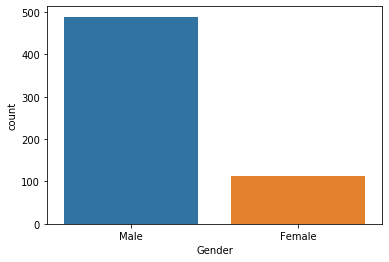

In [30]:
init_look(train, 'Gender')

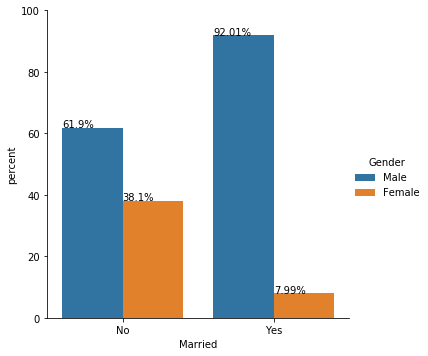

In [33]:
breakdown(train, 'Married', 'Gender')

* 80%+ of applicants are male
* If married, overwhelmingly male

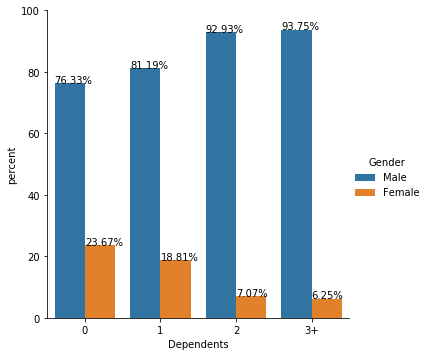

In [34]:
breakdown(train, 'Dependents', 'Gender')

* More independents implies more likely male

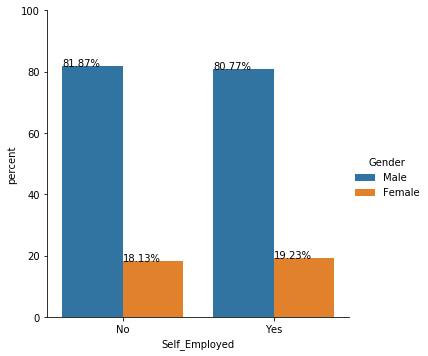

In [37]:
breakdown(train, 'Self_Employed', 'Gender')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


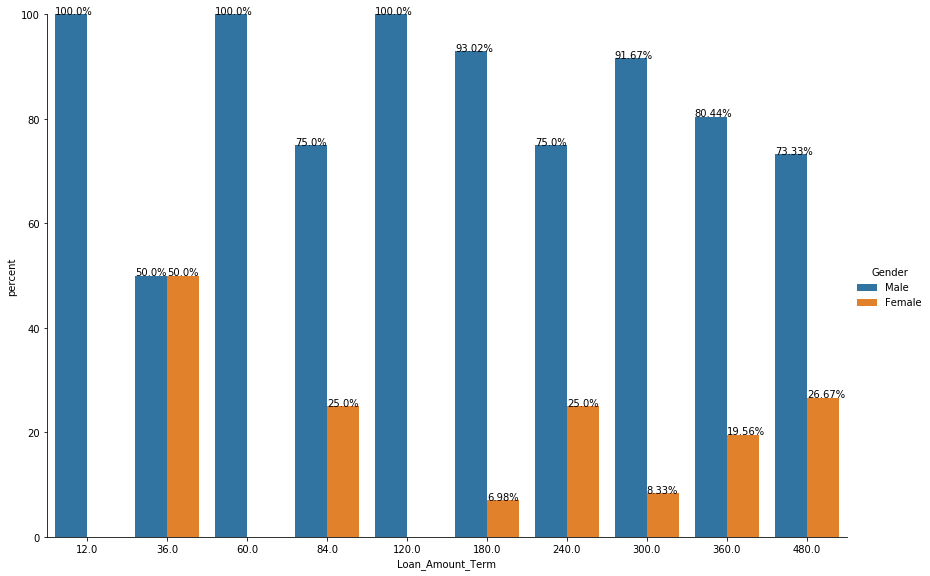

In [40]:
breakdown(train, 'Loan_Amount_Term', 'Gender', size=(8,1.5))

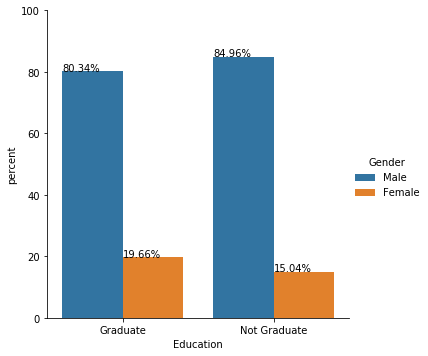

In [41]:
breakdown(train, 'Education', 'Gender')

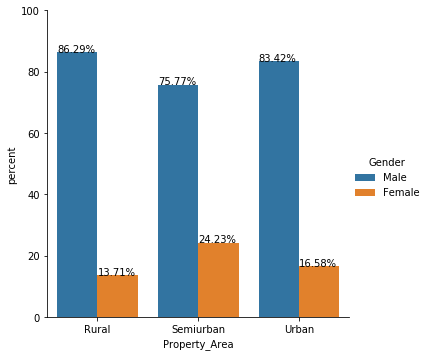

In [42]:
breakdown(train, 'Property_Area', 'Gender')

Married and dependents seem to be best to use for imputation

Lets check the breakdown based on grouping with married and dependents

In [52]:
data = train.groupby(['Married', 'Dependents', 'Gender'])['ApplicantIncome'].count().unstack()
data.replace(np.nan, 0,inplace=True)
data['Total'] = data['Female'] + data['Male']
data['P(Male)'] = data['Male'] / data['Total']
data['MF'] = data['P(Male)'].apply(lambda x: 'Male' if x >= 0.5 else 'Female')
data

Gender              Female   Male  Total   P(Male)      MF
Married Dependents                                        
No      0             60.0  109.0  169.0  0.644970    Male
        1             13.0   10.0   23.0  0.434783  Female
        2              2.0    6.0    8.0  0.750000    Male
        3+             3.0    3.0    6.0  0.500000    Male
Yes     0             20.0  149.0  169.0  0.881657    Male
        1              6.0   72.0   78.0  0.923077    Male
        2              5.0   86.0   91.0  0.945055    Male
        3+             0.0   42.0   42.0  1.000000    Male

If applicant is not married and has 1 dependent, assume missing gender is female, otherwise, assume male

## Married

Yes    0.651391
No     0.348609
Name: Married, dtype: float64


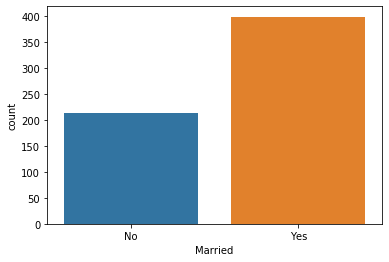

In [43]:
init_look(train, 'Married')

* 65% all applicants are married

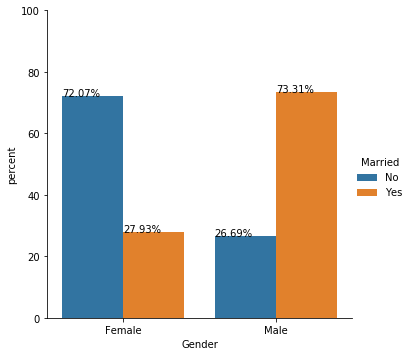

In [44]:
breakdown(train, 'Gender', 'Married')

* Female applicant tends to not be married

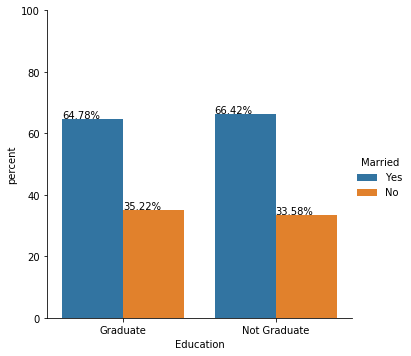

In [45]:
breakdown(train, 'Education', 'Married')

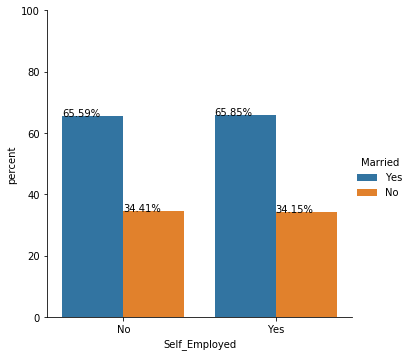

In [46]:
breakdown(train, 'Self_Employed', 'Married')

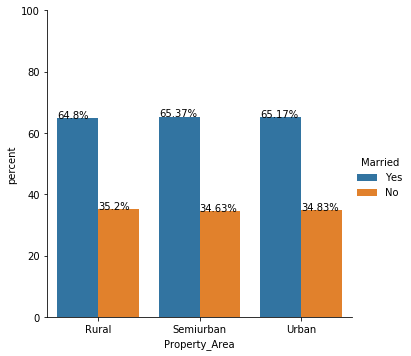

In [47]:
breakdown(train, 'Property_Area', 'Married')

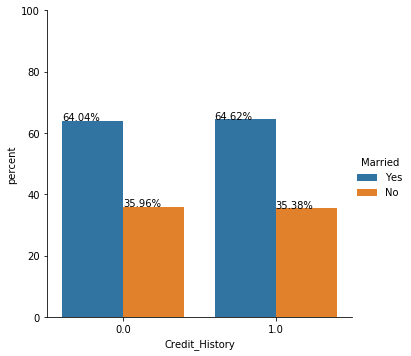

In [48]:
breakdown(train, 'Credit_History', 'Married')

Gender seems to be the only indicator of married or not

Lets check the breakdown of gender and marriage

In [49]:
data = train.groupby(['Gender', 'Married'])['ApplicantIncome'].count().unstack()
data['Total'] = data['Yes'] + data['No']
data['P(Married)'] = data['Yes'] / data['Total']
data['M'] = data['P(Married)'].apply(lambda x: 'Married' if x >= 0.5 else 'Not Married')

data

Married,No,Yes,Total,P(Married),M
Gender,,,,,
Female,80,31,111,0.279279,Not Married
Male,130,357,487,0.733060,Married


If applicant is female, assume not married, otherwise assume married

## Dependents

0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64


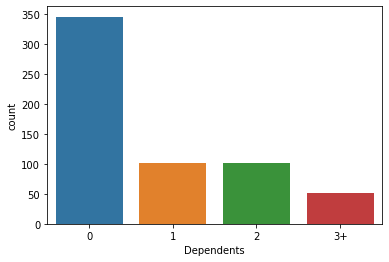

In [50]:
init_look(train, 'Dependents')

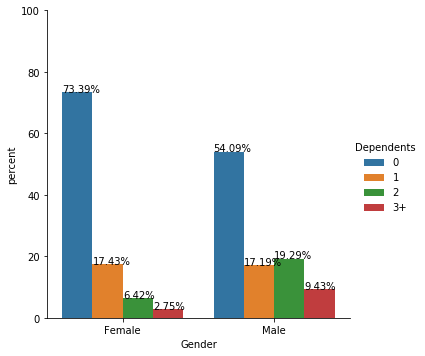

In [51]:
breakdown(train, 'Gender', 'Dependents')

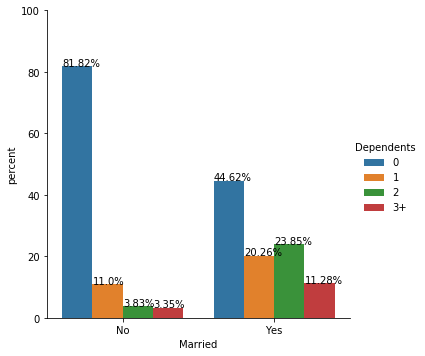

In [52]:
breakdown(train, 'Married', 'Dependents')

Not married implies no dependents, married, implies much better chance of dependents

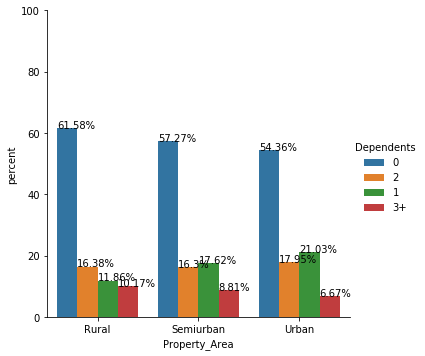

In [53]:
breakdown(train, 'Property_Area', 'Dependents')

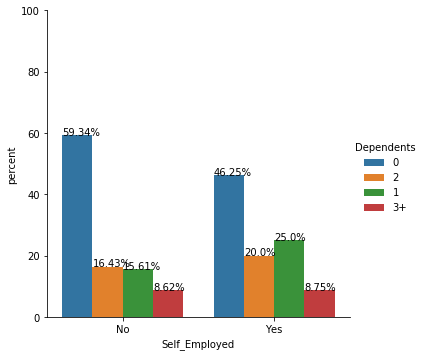

In [54]:
breakdown(train, 'Self_Employed', 'Dependents')

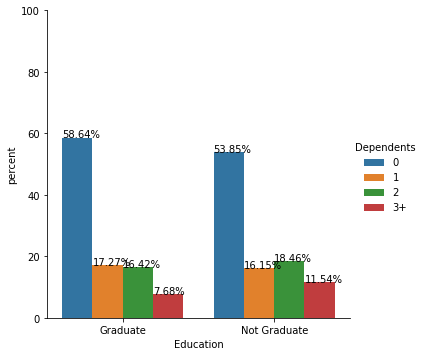

In [55]:
breakdown(train, 'Education', 'Dependents')

Let's check the breakdown of marriage and property area for dependents.  Let's also turn dependents into an integer and take the mean instead of breaking down probabilities for each category.

In [ ]:
def dependents_to_int(x):
    if pd.isnull(x):
        return np.nan
    elif x == '3+':
        return 3
    else:
        return int(x)

train['Depends'] = train['Dependents'].apply(lambda x: dependents_to_int(x))

In [ ]:
data = train.groupby(['Married', 'Property_Area', 'Dependents'])['ApplicantIncome'].count().unstack()
data.replace(np.nan, 0, inplace=True)
data['Total'] = data['0'] + data['1'] + data['2'] + data['3+']
data['P(0)'] = data['0'] / data['Total']
data['P(1)'] = data['1'] / data['Total']
data['P(2)'] = data['2'] / data['Total']
data['P(3+)'] = data['3+'] / data['Total']
#data['M'] = data['P(Married)'].apply(lambda x: 'Married' if x >= 0.5 else 'Not Married')

data

In [59]:
data = train.groupby(['Married', 'Property_Area'])['Depends'].mean()
data

Married  Property_Area
No       Rural            0.317460
         Semiurban        0.303797
         Urban            0.238806
Yes      Rural            0.991228
         Semiurban        1.013514
         Urban            1.046875
Name: Depends, dtype: float64

If married, have 1 dependent, property area does not matter.  Let's check the breakdown with gender instead of property area.

In [58]:
data = train.groupby(['Married', 'Gender'])['Depends'].mean()
data

Married  Gender
No       Female    0.333333
         Male      0.242188
Yes      Female    0.516129
         Male      1.060172
Name: Depends, dtype: float64

If married and male, assume 1 dependent, otherwise assume no dependent

## Self Employed

No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64


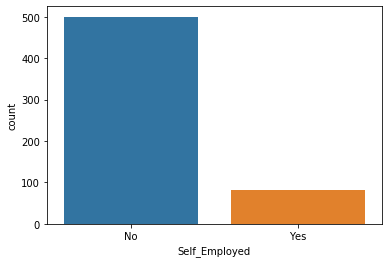

In [60]:
init_look(train, 'Self_Employed')

Most applicants are ****not**** self employed

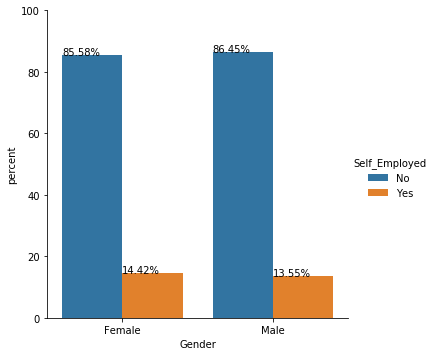

In [61]:
breakdown(train, 'Gender', 'Self_Employed')

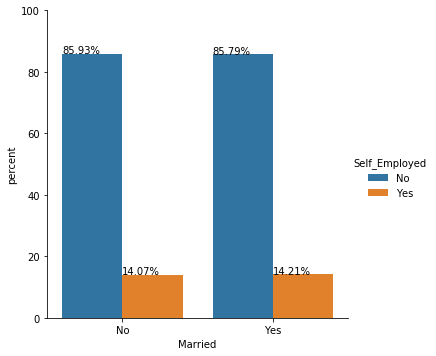

In [62]:
breakdown(train, 'Married', 'Self_Employed')

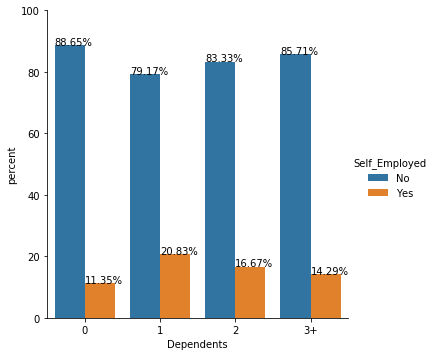

In [63]:
breakdown(train, 'Dependents', 'Self_Employed')

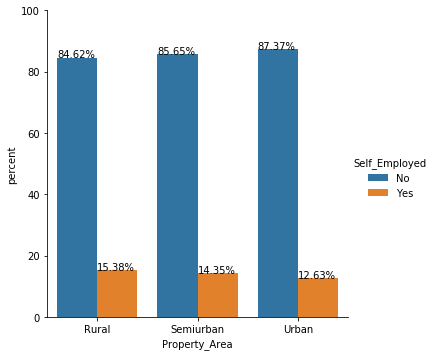

In [64]:
breakdown(train, 'Property_Area', 'Self_Employed')

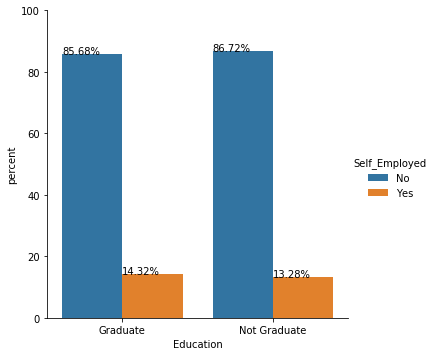

In [65]:
breakdown(train, 'Education', 'Self_Employed')

In [66]:
train.groupby(['Self_Employed'])['ApplicantIncome'].mean()

Self_Employed
No     5049.748000
Yes    7380.817073
Name: ApplicantIncome, dtype: float64

No discernible breakdown to help with self employed or not, so assume applicant is not self employed if missing

## LoanAmount

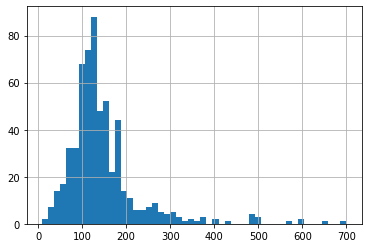

In [67]:
train['LoanAmount'].hist(bins=50)

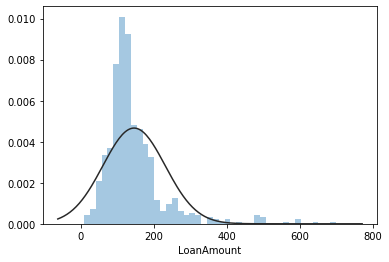

In [68]:
data = train['LoanAmount']
data.dropna(inplace=True)
sns.distplot(data, kde=False, fit=stats.norm)

In [69]:
train['LoanAmountLog'] = np.log(train['LoanAmount'].astype('float64'))

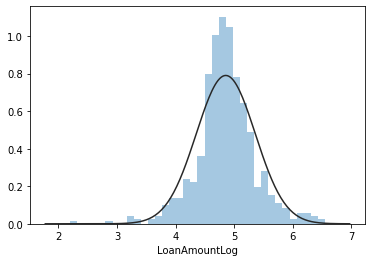

In [70]:
data = train['LoanAmountLog']
data.dropna(inplace=True)
sns.distplot(data, kde=False, fit=stats.norm)

In [71]:
mu = data.mean()
mu

4.857444178729353

In [72]:
np.exp(mu)

128.69486035580871

In [73]:
train['LoanAmount'].mean()

146.41216216216216

Could log transform to create a more normal distribution, and then use that mean (converted back) as the value for missing loan values.  But I want to see if there are differences between loan term groups and loan amount.  Do the same thing (log transform) but per loan term group.

## Loan Amount Term

In [74]:
def loanClass(x):
    if np.isnan(x):
        return np.nan
    else:
        x = int(x)
        if x == 360:
            return '30'
        elif x == 180:
            return '15'
        elif x < 180:
            return '<15'
        elif x > 180 and x < 360:
            return '(15, 30)'
        elif x > 360:
            return '>30'
        else:
            return '??'

In [75]:
train['LoanTerm'] = train['Loan_Amount_Term'].apply(lambda x: loanClass(x))

30          0.853333
15          0.073333
(15, 30)    0.028333
>30         0.025000
<15         0.020000
Name: LoanTerm, dtype: float64


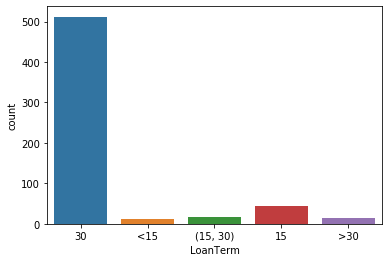

In [76]:
init_look(train, 'LoanTerm')

Most applications are for 30 yr loan

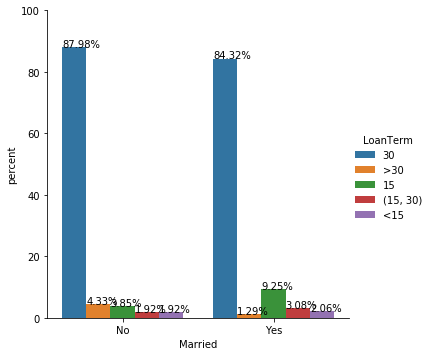

In [77]:
breakdown(train, 'Married', 'LoanTerm')

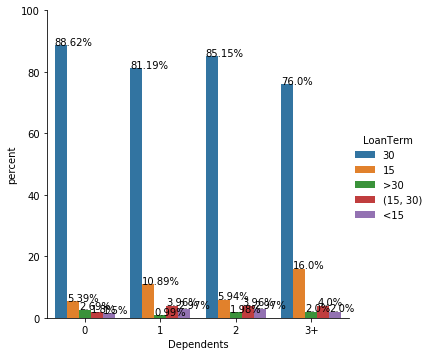

In [78]:
breakdown(train, 'Dependents', 'LoanTerm')

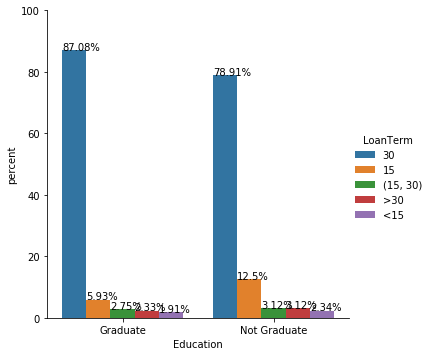

In [79]:
breakdown(train, 'Education', 'LoanTerm')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


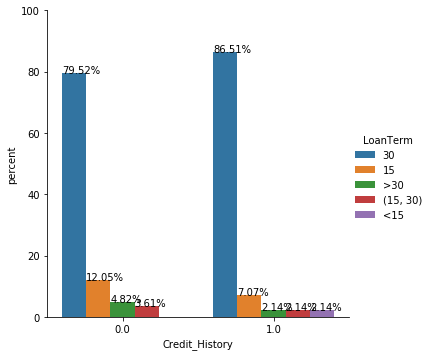

In [80]:
breakdown(train, 'Credit_History', 'LoanTerm')

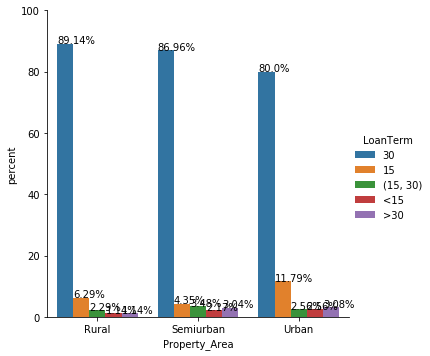

In [81]:
breakdown(train, 'Property_Area', 'LoanTerm')

Urban has a larger proportion of 15 year loans, see if we can find a reason here.  Look at only data from urban property area.

In [84]:
urb = train.loc[train['Property_Area'] == 'Urban']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


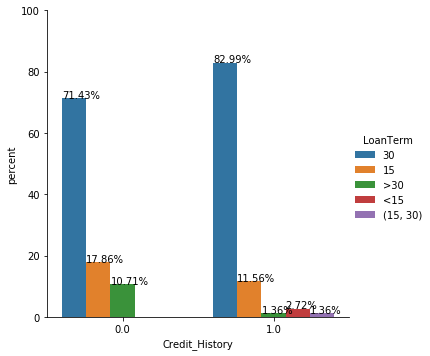

In [85]:
breakdown(urb, 'Credit_History', 'LoanTerm')

No credit history for urban households imply a lower proportion of 30 year loans.  Look into data of only urban and no credit history

In [86]:
no_cred = urb.loc[urb['Credit_History'] == 0.0]

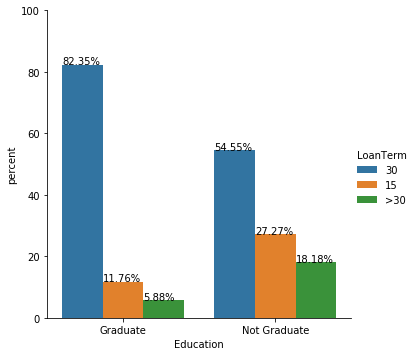

In [87]:
breakdown(no_cred, 'Education', 'LoanTerm')

30 year loan still majoryit, if missing loan term, assume 30 year loan.

In [89]:
#if missing replace with most likely loan term of 30 years
#create groups of loans
def loan_group(x):
    if np.isnan(x):
        return '30'
    else:
        x = int(x)
        if x == 360:
            return '30'
        elif x == 180:
            return '15'
        elif x < 180:
            return '<15'
        elif x > 180 and x < 360:
            return '(15, 30)'
        elif x > 360:
            return '>30'
        else:
            return '??'
        
def loan_ordinal(x):
    if np.isnan(x):
        return 360.0
    else:
        return float(x)
    
    
def loan_term_clean(df):
    df['LoanGroups'] = df['Loan_Amount_Term'].apply(lambda x: loan_group(x))
    df['LoanTerm'] = df['Loan_Amount_Term'].apply(lambda x: loan_ordinal(x))
    #df.drop(columns = ['Loan_Amount_Term'], inplace = True)
    return df

In [90]:
train = loan_term_clean(train)

Check loan amount breakdown for each loan term

In [94]:
train['LoanAmountLog'] = np.log(train['LoanAmount'].astype('float64'))
group = train.groupby(['LoanGroups'])['LoanAmountLog'].mean()
np.exp(group)

LoanGroups
(15, 30)    130.755539
15          123.303018
30          130.606229
<15          80.984445
>30         125.534831
Name: LoanAmountLog, dtype: float64

Loan amount is pretty close/similar for all except for less than 15 year loan.  Could just do two groups, will keep with these groups for now.

## Credit History

1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64


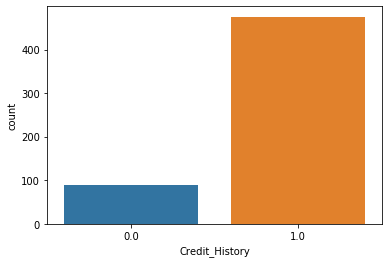

In [96]:
init_look(train, 'Credit_History')

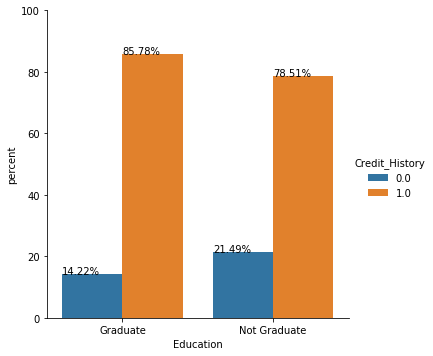

In [97]:
breakdown(train, 'Education', 'Credit_History')

No Education has a slightly higher probability of no credit history.  Check the breakdowns for no education data

In [98]:
noEd = train.loc[train['Education'] == 'Not Graduate']

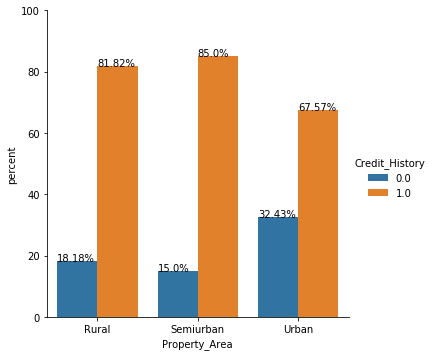

In [99]:
breakdown(noEd, 'Property_Area', 'Credit_History')

Urban area with no education has a large (ish) proportion of no credit history.  But still not a majority.  Check breakdown for no education and urban area data

In [101]:
noEdUrban = noEd.loc[noEd['Property_Area'] == 'Urban']

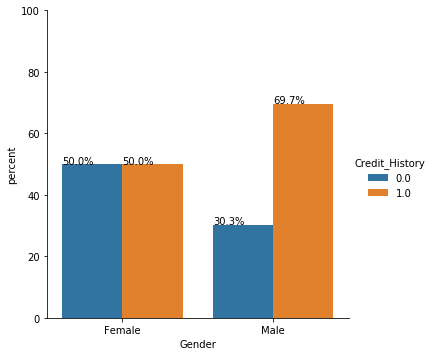

In [102]:
breakdown(noEdUrban, 'Gender', 'Credit_History')

In [103]:
noEdUrban['Gender'].value_counts()

Male      36
Female     4
Name: Gender, dtype: int64

Only 4 data values is too small to make a judgement from

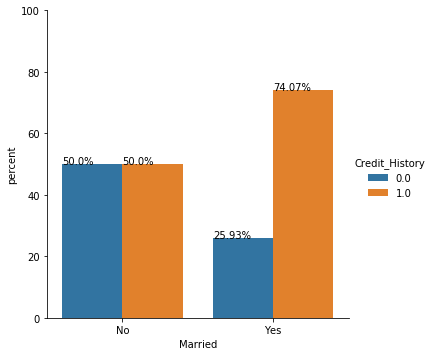

In [105]:
breakdown(noEdUrban, 'Married', 'Credit_History')

In [104]:
noEdUrban['Married'].value_counts()

Yes    29
No     11
Name: Married, dtype: int64

Could possibly use married as the final check for credit history

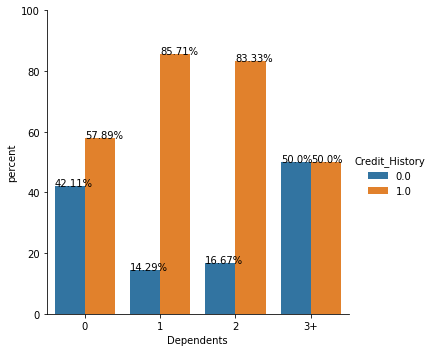

In [110]:
breakdown(noEdUrban, 'Dependents', 'Credit_History')

In [106]:
noEdUrban['Dependents'].value_counts()

0     19
1      9
2      7
3+     4
Name: Dependents, dtype: int64

Too small of data values to make a judgement from

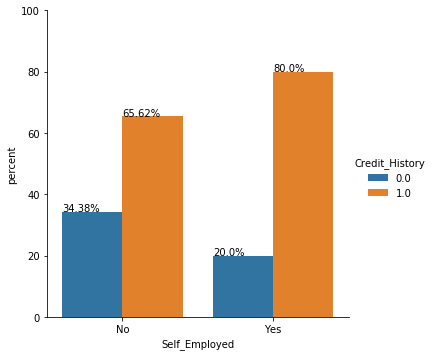

In [111]:
breakdown(noEdUrban, 'Self_Employed', 'Credit_History')

In [112]:
noEdUrban['FamilyIncome'] = noEdUrban['ApplicantIncome'] = noEdUrban['CoapplicantIncome']
x,y = 'Credit_History', 'Loan_Amount_Term'

df1 = noEdUrban.groupby(x)[y].mean()
df1

C:\Users\joepo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Credit_History
0.0    332.727273
1.0    292.173913
Name: Loan_Amount_Term, dtype: float64

In [113]:
train['FamilyIncome'] = train['ApplicantIncome'] = train['CoapplicantIncome']
x,y = 'Credit_History', 'FamilyIncome'

df1 = train.groupby(x)[y].mean()
df1

Credit_History
0.0    1542.179775
1.0    1528.250358
Name: FamilyIncome, dtype: float64

In [108]:
data = train.groupby(['Education', 'Property_Area', 'Married', 'Credit_History'])['ApplicantIncome'].count().unstack()
data['Total'] = data[0.0] + data[1.0]
data['P(No Hist)'] = data[0.0] / data['Total']

data

Credit_History                       0.0    1.0  Total  P(No Hist)
Education    Property_Area Married                                
Graduate     Rural         No        7.0   36.0   43.0    0.162791
                           Yes      13.0   65.0   78.0    0.166667
             Semiurban     No       12.0   49.0   61.0    0.196721
                           Yes      12.0  102.0  114.0    0.105263
             Urban         No        7.0   46.0   53.0    0.132075
                           Yes      12.0   79.0   91.0    0.131868
Not Graduate Rural         No        1.0   16.0   17.0    0.058824
                           Yes       7.0   20.0   27.0    0.259259
             Semiurban     No        NaN   15.0    NaN         NaN
                           Yes       6.0   19.0   25.0    0.240000
             Urban         No        5.0    5.0   10.0    0.500000
                           Yes       7.0   20.0   27.0    0.259259

Most likely to not have a credit history if not graduate and urban and not married, but not enough to assume no credit history.  If missing, assume applicant has a credit history

During EDA, this seemed likely to be our most important variable, may have to look into a model to predict or a different impuatation technique